In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# -----------------------------
# Pauli matrices (system)
# -----------------------------
I2 = np.eye(2, dtype=complex)
X  = np.array([[0, 1], [1, 0]], dtype=complex)
Y  = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z  = np.array([[1, 0], [0, -1]], dtype=complex)

def kron(A, B):
    return np.kron(A, B)


# Model, toggling frame, and moment-cancellation target

We consider a system–bath Hamiltonian with ideal, instantaneous Pauli π-pulses on the system. In the toggling (interaction) frame defined by the pulse-driven reference evolution, the system-bath interaction acquires **piecewise-constant sign functions** $y_\alpha(t)\in\{\pm1\}$ determined solely by the pulse sequence. 

The weak-coupling objective is to design $y_\alpha(t)$ so the total error satisfies

$$
\|U(T)-U_0(T)\| = O(JT^{K+1}) + O(J^2T^2),
$$

i.e., all contributions **linear in $J$** vanish through order $K$ in time. 

This is achieved by enforcing vanishing **generalized moments**
$$
M_{\alpha,m}=\int_0^1 y_\alpha(\tau) \tau^m d\tau = 0,\quad m=0,\dots,K-1,
$$
so the first Magnus term $\Omega_1(T)$ starts at order $T^{K+1}$. 


In [1]:
# -----------------------------
# Frames and signs (I, X, Y, Z)
# -----------------------------
FRAME_TO_IDX = {"I": 0, "X": 1, "Y": 2, "Z": 3}
IDX_TO_FRAME = ["I", "X", "Y", "Z"]

# Rows correspond to I, X, Y, Z (same convention as your code)
FRAME_SIGNS = np.array([
    [ 1.0,  1.0,  1.0],  # I
    [ 1.0, -1.0, -1.0],  # X
    [-1.0,  1.0, -1.0],  # Y
    [-1.0, -1.0,  1.0],  # Z
], dtype=float)

def softmax(z: np.ndarray) -> np.ndarray:
    z = z - np.max(z)
    e = np.exp(z)
    return e / np.sum(e)

def pattern_frames(L: int, cycle=("I", "X", "Y", "Z")):
    cycle = list(cycle)
    return [cycle[i % len(cycle)] for i in range(L)]

# -----------------------------
# Moment residuals (vectorized)
# -----------------------------
def moment_residuals(theta: np.ndarray, k: int, T: float, s_mat: np.ndarray) -> np.ndarray:
    """
    Residual vector in R^{3k}. Durations are positive and sum to T via softmax(theta).
    s_mat: (L,3) sign vectors for each segment.
    """
    durs = T * softmax(theta)   # (L,)
    t = np.empty(durs.size + 1, dtype=float)
    t[0] = 0.0
    np.cumsum(durs, out=t[1:])
    t[-1] = T  # guard exact endpoint

    # powers 1..k
    powers = np.arange(1, k + 1, dtype=float)         # (k,)
    t_pows = t[:, None] ** powers[None, :]            # (L+1, k)
    delta = t_pows[1:] - t_pows[:-1]                  # (L, k)
    acc = delta.T @ s_mat                             # (k, 3)

    return acc.ravel()  # (3k,)

def solve_durations_for_frames(
    k: int,
    T: float,
    frames,
    restarts: int = 6,
    seed: int = 0,
    max_nfev: int = 40000,
):
    """
    For a fixed frame pattern, optimize durations to solve 3k moment equations.
    Returns:
      durs_frac: length L, sums to 1 (fractions of T)
      best_resn: residual 2-norm at the best restart
    """
    L = len(frames)
    frames_idx = np.fromiter((FRAME_TO_IDX[f] for f in frames), dtype=int, count=L)
    s_mat = FRAME_SIGNS[frames_idx]  # (L,3)

    res_fun = lambda th: moment_residuals(th, k, T, s_mat)

    rng = np.random.default_rng(seed)
    best_x = None
    best_resn = np.inf

    for _ in range(restarts):
        th0 = rng.standard_normal(L) * 0.5
        sol = least_squares(
            res_fun,
            th0,
            method="trf",
            ftol=1e-14, xtol=1e-14, gtol=1e-14,
            max_nfev=max_nfev,
        )
        resn = np.linalg.norm(res_fun(sol.x))
        if resn < best_resn:
            best_resn = resn
            best_x = sol.x

    durs_frac = softmax(best_x)   # sums to 1
    return durs_frac, best_resn

# -----------------------------
# Random Hermitian (normalized)
# -----------------------------
def rand_hermitian(n: int, rng: np.random.Generator) -> np.ndarray:
    A = rng.standard_normal((n, n)) + 1j * rng.standard_normal((n, n))
    H = (A + A.conj().T) / 2.0
    w = np.linalg.eigvalsh(H)
    return H / np.max(np.abs(w))

# -----------------------------
# Lab Hamiltonian + fast exp(-iH dt)
# -----------------------------
def H_lab(J, HB, Bx, By, Bz):
    return kron(I2, HB) + J * (kron(X, Bx) + kron(Y, By) + kron(Z, Bz))

def make_free_evolver(H: np.ndarray):
    """
    Returns a function U(dt) = exp(-i H dt) using a single eigh decomposition.
    H must be Hermitian.
    """
    w, V = np.linalg.eigh(H)
    Vh = V.conj().T

    def U(dt: float) -> np.ndarray:
        ph = np.exp(-1j * w * dt)
        return (V * ph[None, :]) @ Vh

    return U

# -----------------------------
# Pulse compilation (fast transitions)
# -----------------------------
def build_pulses(dimB: int):
    IB = np.eye(dimB, dtype=complex)
    return [
        kron(X, IB),  # x
        kron(Y, IB),  # y
        kron(Z, IB),  # z
    ]

def build_transition_axis():
    """
    Axis codes: -1 means no pulse, 0->x, 1->y, 2->z.
    Between different frames, exactly two signs flip; pulse is about the remaining axis.
    """
    trans = -np.ones((4, 4), dtype=int)
    for a in range(4):
        for b in range(4):
            if a == b:
                trans[a, b] = -1
                continue
            flips = (FRAME_SIGNS[a] != FRAME_SIGNS[b])
            if flips.sum() != 2:
                raise ValueError(f"Invalid transition {IDX_TO_FRAME[a]}->{IDX_TO_FRAME[b]}")
            axis = int(np.where(~flips)[0][0])
            trans[a, b] = axis
    return trans

TRANS_AXIS = build_transition_axis()

def compile_sequence(frames):
    """
    Precompute all boundary pulses for a given frame list.
    Returns a dict used by unitary_sequence_pulse_compiled.
    """
    frames_idx = np.fromiter((FRAME_TO_IDX[f] for f in frames), dtype=int, count=len(frames))

    init_axis = TRANS_AXIS[0, frames_idx[0]] if (frames_idx.size and frames_idx[0] != 0) else -1
    between_axes = np.array(
        [TRANS_AXIS[frames_idx[i], frames_idx[i + 1]] for i in range(frames_idx.size - 1)],
        dtype=int
    ) if frames_idx.size > 1 else np.array([], dtype=int)
    final_axis = TRANS_AXIS[frames_idx[-1], 0] if (frames_idx.size and frames_idx[-1] != 0) else -1

    return {
        "frames_idx": frames_idx,
        "init_axis": init_axis,
        "between_axes": between_axes,
        "final_axis": final_axis,
    }

def unitary_sequence_pulse_compiled(seq, durs_frac, T, free_evolver, pulses):
    """
    Apply boundary pi-pulses (instantaneous), and free-evolve under fixed lab H.
    durs_frac sums to 1; each segment uses dt = durs_frac[i] * T.
    """
    d = pulses[0].shape[0]
    U = np.eye(d, dtype=complex)

    ax0 = seq["init_axis"]
    if ax0 != -1:
        U = pulses[ax0] @ U

    between_axes = seq["between_axes"]
    for i, frac in enumerate(durs_frac):
        dt = float(frac) * float(T)
        if dt > 0:
            U = free_evolver(dt) @ U
        if i < between_axes.size:
            ax = between_axes[i]
            if ax != -1:
                U = pulses[ax] @ U

    axf = seq["final_axis"]
    if axf != -1:
        U = pulses[axf] @ U

    return U

# -----------------------------
# Operator (spectral) norm + slope fit
# -----------------------------
def op_norm(A: np.ndarray) -> float:
    return float(np.linalg.norm(A, 2))

def fit_loglog_slope(xs, ys, drop_edges=3):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    lo, hi = drop_edges, len(xs) - drop_edges
    x = np.log(xs[lo:hi])
    y = np.log(np.maximum(ys[lo:hi], 1e-300))
    a, _ = np.polyfit(x, y, 1)
    return a


# Constructing/optimizing pulse timings under a fixed frame pattern

For single-qubit general decoherence, the decoupling group can be chosen as the single-qubit Pauli group $G=\{I,X,Y,Z\}$, implying an existence bound of $(|G|-1)K=3K$ pulses (up to one extra pulse to enforce cyclicity $U_c(T)=I$). 

Following the paper’s numerical approach, we:
- Fix the **number of segments** $L=3K+1$ (so pulse count is $3K$),
- Fix a **pulse pattern** (e.g., alternating $X\rightarrow Z\rightarrow X\rightarrow Z\cdots$),
- Optimize only the normalized segment lengths $\Delta\tau_\ell>0$ with $\sum_\ell \Delta\tau_\ell=1$. 

Because each switching function $y_\alpha(\tau)$ is piecewise constant, all moment integrals are evaluated analytically. The residual vector stacks the moment constraints across $\alpha\in\{x,y,z\}$ and $m=0,\dots,K-1$, and we minimize its squared norm via nonlinear least squares.

To enforce the simplex constraint, we parameterize $\Delta\tau$ using a softmax map and solve the resulting unconstrained least-squares problem with a trust-region reflective method (SciPy `least_squares`).


In [2]:
solutions = {}

for k in range(1, 9):
    L = 3 * k + 1
    frames = pattern_frames(L, ("I", "X", "Y", "Z"))
    durs_frac, resn = solve_durations_for_frames(
        k=k, T=1.0, frames=frames,
        restarts=8, seed=100 + k, max_nfev=100000
    )
    solutions[k] = {
        "k": k,
        "L": L,
        "frames": frames,
        "seq": compile_sequence(frames),
        "durs_frac": durs_frac,
        "residual_norm": resn,
    }
    print(f"[k={k}] L={L}, residual_norm={resn:.3e}, sum(durs)={durs_frac.sum():.12f}")


[k=1] L=4, residual_norm=1.444e-15, sum(durs)=1.000000000000
[k=2] L=7, residual_norm=2.949e-14, sum(durs)=1.000000000000
[k=3] L=10, residual_norm=4.024e-14, sum(durs)=1.000000000000
[k=4] L=13, residual_norm=1.313e-13, sum(durs)=1.000000000000
[k=5] L=16, residual_norm=1.968e-12, sum(durs)=1.000000000000
[k=6] L=19, residual_norm=4.028e-13, sum(durs)=1.000000000000
[k=7] L=22, residual_norm=1.906e-14, sum(durs)=1.000000000000
[k=8] L=25, residual_norm=1.258e-14, sum(durs)=1.000000000000


Print the pulse timings explicitly if needed.

In [3]:
np.set_printoptions(precision=17, suppress=False)
for k in range(1, 9):
    print(f"\n--- k = {k} ---")
    print(solutions[k]["durs_frac"])



--- k = 1 ---
[0.25000000000000033 0.2499999999999994  0.2500000000000001
 0.2500000000000003 ]

--- k = 2 ---
[0.0784648345913908  0.12500000000000708 0.17153516540863972
 0.2499999999999915  0.17153516540861596 0.12499999999999331
 0.07846483459136162]

--- k = 3 ---
[0.03229282665331357 0.06319867615930472 0.09832227933964588
 0.15167772066046795 0.15450849718745166 0.15450849718747509
 0.15167772066035567 0.09832227933952668 0.06319867615923835
 0.03229282665322022]

--- k = 4 ---
[0.01574055856869887 0.03484099377950485 0.05832672742308866
 0.09263933792230888 0.10925944143211813 0.12251966830020618
 0.13334654515537975 0.12251966829912525 0.10925944143151779
 0.09263933792028893 0.05832672742153359 0.03484099377856052
 0.01574055856766845]

--- k = 5 ---
[0.00859923929960205 0.02071462007454601 0.0364887917201138
 0.05919734867578728 0.07530058372921317 0.0897480953895134
 0.10304849262474798 0.10690282813545901 0.1069028281306978
 0.10304849270097233 0.08974809550519455 0.07530

# Simulation with instantaneous pulses 

We simulate the full unitary evolution under ideal instantaneous π-pulses and compare it to the reference evolution with zero coupling $J=0$. The operator-norm error metric used here is
$$
\|U(T)-U_0(T)\|,
$$
which is the same “unitary-level” error notion used when discussing the weak-coupling scaling target. 

In the weak-coupling regime, the leading expected behavior is
$$
\|U(T)-U_0(T)\| = O(JT^{K+1}) + O(J^2T^2),
$$
so as $J$ becomes small, the observed slope in a log–log plot should approach the designed cancellation order. 

k=1: slope_hi ≈ 1.914
k=2: slope_hi ≈ 2.997
k=3: slope_hi ≈ 4.102
k=4: slope_hi ≈ 4.923


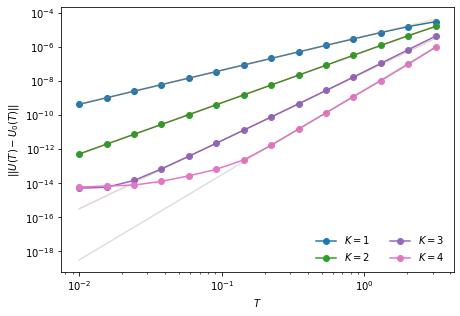

In [6]:
# Random bath/coupling operators
rng = np.random.default_rng(100)
nB = 2
HB = rand_hermitian(nB, rng)
Bx = rand_hermitian(nB, rng)
By = rand_hermitian(nB, rng)
Bz = rand_hermitian(nB, rng)

# Sweep in T
Ts = np.logspace(-2.0, 0.5, 14)

# Small coupling strength
J0 = 1e-5

# Precompute pulse matrices once
pulses = build_pulses(nB)

# Build two fixed lab Hamiltonians and their fast evolvers
Ufree_0 = make_free_evolver(H_lab(0.0, HB, Bx, By, Bz))
Ufree_J = make_free_evolver(H_lab(J0,  HB, Bx, By, Bz))

# Choose which k values to plot
k_list = [1, 2, 3, 4]

errs_by_k = {}
ref_by_k = {}

for k in k_list:
    seq = solutions[k]["seq"]
    durs = solutions[k]["durs_frac"]

    errs = []
    for T in Ts:
        U0 = unitary_sequence_pulse_compiled(seq, durs, T, Ufree_0, pulses)
        U  = unitary_sequence_pulse_compiled(seq, durs, T, Ufree_J, pulses)
        errs.append(op_norm(U - U0))

    errs = np.array(errs)
    errs_by_k[k] = errs

    # Reference ~ T^(k+1) line anchored at the middle point (for visual slope guide)
    mid = len(Ts) // 2
    ref_by_k[k] = (errs[mid] / (Ts[mid] ** (k + 1))) * (Ts ** (k + 1))

    # If you want a quick slope estimate:
    slope_hi = np.polyfit(np.log(Ts[-8:]), np.log(np.maximum(errs[-8:], 1e-300)), 1)[0]
    print(f"k={k}: slope_hi ≈ {slope_hi:.3f}")

# ---- One plot: operator-norm error only ----
plt.figure(figsize=(6.5, 4.5))

for k in k_list:
    plt.loglog(Ts, errs_by_k[k], marker="o", label=rf"$K={k}$")
    plt.loglog(Ts, ref_by_k[k], alpha=0.25)

plt.xlabel(r"$T$")
plt.ylabel(r"$||U(T)-U_0(T)\||$")
plt.legend(loc="lower right", ncol=2, frameon=False)
plt.tight_layout()
plt.show()
